In [ ]:
# INSTALL & IMPORT
import os, re, json, zipfile
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from transformers import AutoTokenizer, TFDistilBertModel, logging as hf_logging
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

hf_logging.set_verbosity_error()
print(" All libraries are installed and imported successfully.")



 All libraries are installed and imported successfully.


In [ ]:
# LOAD & PREPARE DATA
print("\n Loading and Preprocessing Data ")
from google.colab import files

print("Please upload the 'archive.zip' file.")
uploaded = files.upload()
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

fake_df = pd.read_csv('/content/data/Fake.csv')
true_df = pd.read_csv('/content/data/True.csv')

def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', str(text))
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Leakage fix
true_df['text'] = true_df['text'].astype(str).apply(lambda x: x.split(' - ', 1)[-1])

fake_df['label'] = 1
true_df['label'] = 0

df = pd.concat([fake_df, true_df]).sample(frac=1, random_state=42).reset_index(drop=True)
df['content'] = (df['title'].astype(str) + ' ' + df['text'].astype(str)).apply(clean_text)
df = df[['content', 'label']]

X_train, X_temp, Y_train, Y_temp = train_test_split(
    df['content'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp
)
print(f"Test data size: {len(X_test)}")



 Loading and Preprocessing Data 
Please upload the 'archive.zip' file.


Saving archive.zip to archive.zip
Test data size: 4490


In [ ]:
# SECTION 2: REBUILD MODEL & LOAD WEIGHTS
print("\n Loading Tokenizer, Rebuilding Model, and Weights ")
from google.colab import drive
drive.mount('/content/drive')

# Folder with artifacts
ARTIFACTS_DIR = Path("/content/drive/MyDrive/fake_news_models_distil/Latest_DistilBert")

# 2.1 Config
config_path = ARTIFACTS_DIR / "config.json"
if not config_path.exists():
    raise FileNotFoundError(f"No config.json at {config_path}")
config = json.loads(config_path.read_text())
MODEL_NAME = config.get("model_name", "distilbert-base-uncased")
MAX_LEN    = int(config.get("max_len", 128))
THRESHOLD  = float(config.get("threshold", 0.5))
print(" Config loaded.")

# 2.2 Tokenizer
tokenizer_dir = ARTIFACTS_DIR / "tokenizer"
if not tokenizer_dir.exists():
    raise FileNotFoundError(f"Tokenizer dir not found at {tokenizer_dir}")
tokenizer = AutoTokenizer.from_pretrained(str(tokenizer_dir))
print(" Tokenizer loaded.")

# 2.3 Same model
class TransformerFeatureExtractor(Layer):
    def __init__(self, transformer_model, **kwargs):
        super().__init__(**kwargs)
        self.transformer = transformer_model
    def call(self, inputs):
        return self.transformer(inputs).last_hidden_state

def build_distilbert_model(model_name, max_len):
    base_model = TFDistilBertModel.from_pretrained(model_name, from_pt=True)
    base_model.trainable = False

    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    features = TransformerFeatureExtractor(base_model)(
        {'input_ids': input_ids, 'attention_mask': attention_mask}
    )
    pooled = GlobalAveragePooling1D()(features)
    x = Dropout(0.4)(pooled)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.4)(x)
    out = Dense(1, activation="sigmoid", name="classification")(x)

    model = Model([input_ids, attention_mask], out)
    model.compile(
        optimizer=Adam(learning_rate=2e-5, epsilon=1e-8),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_distilbert_model(MODEL_NAME, MAX_LEN)

# 2.4 Load weights-only
weights_path = ARTIFACTS_DIR / "model.weights.h5"
if not weights_path.exists():
    raise FileNotFoundError(f"Weights not found at {weights_path}")

# Build shapes then load
_ = model({
    "input_ids": tf.zeros((1, MAX_LEN), dtype=tf.int32),
    "attention_mask": tf.zeros((1, MAX_LEN), dtype=tf.int32)
})
model.load_weights(str(weights_path))
print(f" Weights loaded from: {weights_path}")

print("\n--- Model Reload Summary ---")
print(f"   Backbone: {MODEL_NAME}")
print(f"   Max Len : {MAX_LEN}")
print(f"   Threshold: {THRESHOLD}")
model.summary()


 Loading Tokenizer, Rebuilding Model, and Weights 
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Config loaded.
 Tokenizer loaded.
 Weights loaded from: /content/drive/MyDrive/fake_news_models_distil/Latest_DistilBert/model.weights.h5

--- Model Reload Summary ---
   Backbone: distilbert-base-uncased
   Max Len : 128
   Threshold: 0.5


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_featur… │ (None, 128, 768)  │          0 │ attention_mask[0… │
│ (TransformerFeatur… │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ transformer_feat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 768)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     49,216 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │         65 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,281 (192.50 KB)

 Trainable params: 49,281 (192.50 KB)

 Non-trainable params: 0 (0.00 B)

141/141 ━━━━━━━━━━━━━━━━━━━━ 801s 6s/step

Classification Report (Test):
              precision    recall  f1-score   support

    Real (0)       0.94      0.93      0.94      2142
    Fake (1)       0.94      0.94      0.94      2348

    accuracy                           0.94      4490
   macro avg       0.94      0.94      0.94      4490
weighted avg       0.94      0.94      0.94      4490



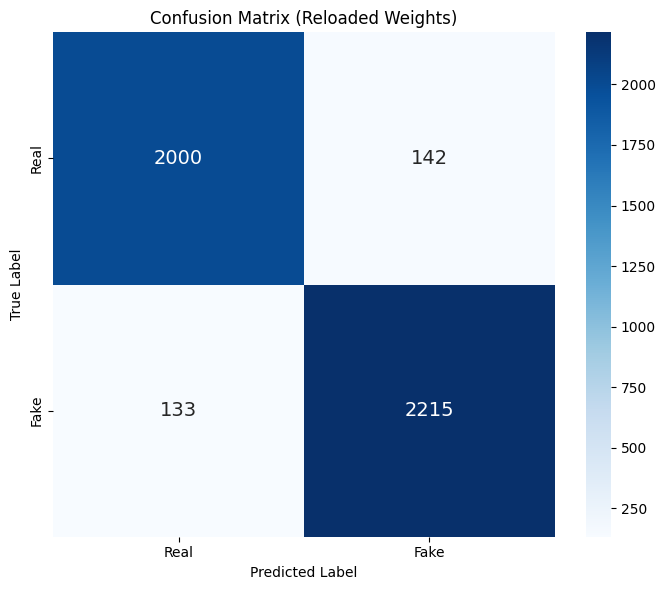

In [ ]:
# EVALUATE ON TEST SET
X_test_tok = tokenizer(
    X_test.tolist(),
    add_special_tokens=True,
    max_length=MAX_LEN,
    truncation=True,
    padding='max_length',
    return_tensors='tf'
)

probs = model.predict(dict(X_test_tok), batch_size=32).flatten()
preds = (probs >= THRESHOLD).astype(int)
y_true = np.array(Y_test).flatten()

print("\nClassification Report (Test):")
print(classification_report(y_true, preds, target_names=['Real (0)', 'Fake (1)']))

cm = confusion_matrix(y_true, preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'],
            annot_kws={"size":14})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Reloaded Weights)")
plt.tight_layout()
plt.show()



In [ ]:
# GRADIO APP
!pip install gradio -q
import gradio as gr

def predict_fake_news(text):
    cleaned = clean_text(text)
    enc = tokenizer(
        cleaned, max_length=MAX_LEN, truncation=True,
        padding='max_length', return_tensors='tf'
    )
    score = model.predict(dict(enc), verbose=0)[0][0]
    return {'FAKE': float(score), 'REAL': float(1.0 - score)}

examples = [
    ["BREAKING: A source close to the White House claims the president is secretly a lizard person."],
    ["The S&P 500 closed up 0.5% after the Fed announcement."],
    ["You will be SHOCKED to learn this one weird trick to lose weight."]
]

gr.Interface(
    fn=predict_fake_news,
    inputs=gr.Textbox(lines=8, placeholder="Paste a news article..."),
    outputs=gr.Label(num_top_classes=2, label="Verdict"),
    title=" DistilBERT Fake News Detector (Weights Reload)",
    description="Loads the DistilBERT model architecture and weights-only for inference.",
    examples=examples
).launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://5e6becf0245d22eefe.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://5e6becf0245d22eefe.gradio.live
